In [42]:
# Notebook cell: Quant POC (use Close, not Adj Close)
# Requirements: yfinance, pandas, numpy, xgboost, scikit-learn, matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# --- 1) Universe: S&P 500 tickers (start small for speed) ---
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
tickers = sp500['Symbol'].tolist()[:120]   # start with 120 tickers for speed
sector_map = sp500.set_index('Symbol')['GICS Sector'].to_dict()

# Remove bad tickers (e.g., BRK.B, BF.B) that may not have data
bad_tickers = ["BF.B", "BRK.B"]
tickers = [t for t in tickers if t not in bad_tickers]
# --- 2) Download OHLCV using Close (NOT Adj Close) ---
start, end = "2015-01-01", pd.Timestamp.today().strftime("%Y-%m-%d")
# request Close and Volume
raw = yf.download(tickers, start=start, end=end, group_by="ticker", auto_adjust=False, threads=True)

# Extract Close and Volume into tidy DataFrames
# raw is multi-index when multiple tickers
closes = {}
vols = {}
for t in tickers:
    try:
        df = raw[t].copy()
        closes[t] = df['Adj Close']
        vols[t] = df['Volume']
    except Exception as e:
        # skip tickers with no data
        print(f"skip {t}: {e}")

close_df = pd.DataFrame(closes).sort_index()
vol_df   = pd.DataFrame(vols).sort_index()

# --- 3) Basic technical features (daily) using Close ---
# daily returns
ret = close_df.pct_change()

# build per-ticker features and stack to long form
features_list = []
for t in close_df.columns:
    s = close_df[t].dropna()
    if len(s) < 252:   # skip very short histories
        continue
    df = pd.DataFrame({
        'date': s.index,
        'ticker': t,
        'close': s.values,
        'ret_1d': s.pct_change().values,
        'momentum_21': s.pct_change(21).shift(1).values,     # ~1 month
        'momentum_63': s.pct_change(63).shift(1).values,     # ~3 months
        'vol_21': s.pct_change().rolling(21).std().shift(1).values,
        'vol_63': s.pct_change().rolling(63).std().shift(1).values,
        'volume': vol_df[t].reindex(s.index).values
    })
    # forward label: 21 trading day forward return (use close)
    df['fwd_ret_21'] = (df['close'].shift(-21) / df['close'] - 1).values
    features_list.append(df)
    # inside your features_list loop where you build df for each ticker:
    dollar_vol = vol_df[t].reindex(s.index) * s  # shares * price
    df['adv_21'] = dollar_vol.rolling(21).mean().values   # 21d avg dollar volume
    # keep vol_21 you already compute as return std; it can proxy volatility in impact


feat = pd.concat(features_list, ignore_index=True)
feat.dropna(subset=['momentum_21','vol_21','fwd_ret_21'], inplace=True)

# add sector
feat['sector'] = feat['ticker'].map(sector_map).fillna('Unknown')

# --- 4) Industry (sector) normalization: industry z-score per date ---
# for numerical stability, compute zscore per (date, sector) group
num_cols = ['momentum_21','momentum_63','vol_21','vol_63','volume']
for col in num_cols:
    # groupby date and sector
    feat[col + '_ind_z'] = feat.groupby(['date','sector'])[col].transform(
        lambda x: (x - x.median()) / (x.std() + 1e-9)
    )

# Also compute sector percentile (robust)
for col in ['momentum_21','momentum_63']:
    feat[col + '_ind_pct'] = feat.groupby(['date','sector'])[col].transform(lambda x: x.rank(pct=True))




[*********************100%***********************]  118 of 118 completed
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\user\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, a

In [43]:
# --- 5) Macro features: VIX and US 10y (from yfinance symbols) ---
raw_vix = yf.download("^VIX", start=start, end=end, auto_adjust=False)

if raw_vix.empty:
    print("⚠️ Failed to download VIX")
else:
    vix = raw_vix['Adj Close']['^VIX'].to_frame(name='vix')  # OK — now 'vix' is a DataFrame

raw_tnx = yf.download("^TNX", start=start, end=end, auto_adjust=False)
if raw_tnx.empty:
    print("⚠️ Failed to download US10Y")
else:
    us10y = raw_tnx['Adj Close']['^TNX'].to_frame(name='us10y')

# Combine macro data (if they exist)
macro_parts = [df for df in [vix, us10y] if df is not None]
macro = pd.concat(macro_parts, axis=1).ffill().pct_change().fillna(0).reset_index().rename(columns={'Date': 'date'})


macro = pd.concat([vix, us10y], axis=1).ffill().pct_change().fillna(0)

#macro = pd.concat([vix, us10y], axis=1).ffill().pct_change().fillna(0)
macro = macro.reset_index().rename(columns={'Date':'date'})

# merge macro features to feat (left join by date)
feat = feat.merge(macro, on='date', how='left')

# Fill macro NaNs forward/back
feat[['vix','us10y']] = feat[['vix','us10y']].fillna(method='ffill').fillna(0)

# --- 6) Prepare model dataset: choose features and label (regression) ---
model_cols = [
    'momentum_21_ind_z', 'momentum_63_ind_z',
    'vol_21_ind_z', 'vol_63_ind_z',
    'volume_ind_z', 'momentum_21_ind_pct',
    'vix', 'us10y'
]
df_model = feat[['date','ticker','close','volume','adv_21','vol_21'] + model_cols + ['fwd_ret_21']].dropna()


# optional: keep only monthly signal dates if you want monthly rebalance (aggregate)
# For now, use daily cross-sectional predictions (we'll aggregate when backtesting)
X = df_model[model_cols]
y = df_model['fwd_ret_21']

# --- 7) Time-series aware CV + XGBoost (quick pass) ---
# We'll do a simple time split: train on first 70% dates, test on last 30%
unique_dates = df_model['date'].sort_values().unique()
cut = int(len(unique_dates) * 0.7)
train_dates = set(unique_dates[:cut])
test_dates  = set(unique_dates[cut:])

train_mask = df_model['date'].isin(train_dates)
test_mask  = df_model['date'].isin(test_dates)

Xtr, Xte = X[train_mask], X[test_mask]
ytr, yte = y[train_mask], y[test_mask]

dtrain = xgb.DMatrix(Xtr, label=ytr)
dtest  = xgb.DMatrix(Xte, label=yte)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "seed": 42
}
model = xgb.train(params, dtrain, num_boost_round=500,
                  evals=[(dtrain,'train'),(dtest,'test')],
                  early_stopping_rounds=30, verbose_eval=False)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\user\AppData\Local\Temp\ipykernel_3176\4133335024.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feat[['vix','us10y']] = feat[['vix','us10y']].fillna(method='ffill').fillna(0)


## Long Short

OOS RMSE: 0.0982999070360183


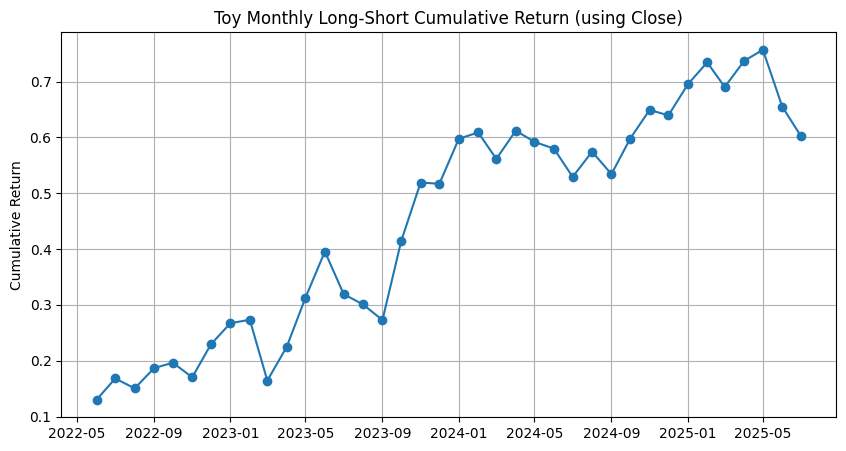

Annualized mean monthly LS return: 0.16135265565065976
Monthly LS std: 0.04506305478131262
Sharpe (annualized, rf=0): 1.0336294291016535


In [63]:
preds = model.predict(xgb.DMatrix(Xte))
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(yte, preds)
rmse = np.sqrt(mse)
print("OOS RMSE:", rmse)


# attach predictions back to df_model for backtest
df_model.loc[test_mask, 'pred'] = preds

# --- 8) Toy monthly long-short backtest (rank-based) ---
# Turn daily preds into monthly signals: at month end, rank tickers and form LS
df_model['month'] = pd.to_datetime(df_model['date']).dt.to_period('M')
monthly = df_model[df_model['date'].isin(df_model.groupby('month')['date'].max().values)]

# for each month, long top 20% and short bottom 20% using the prediction column
monthly_results = []
for m, grp in monthly.groupby('month'):
    grp = grp.dropna(subset=['pred','fwd_ret_21']).copy()
    if len(grp) < 10:
        continue
    grp['rank_pct'] = grp['pred'].rank(pct=True)
    long = grp[grp['rank_pct'] >= 0.8]
    short = grp[grp['rank_pct'] <= 0.2]
    long_ret = long['fwd_ret_21'].mean()
    short_ret = short['fwd_ret_21'].mean()
    # long-short return
    monthly_results.append({'month': m.to_timestamp(), 'ls_ret': long_ret - short_ret,
                            'long_n': len(long), 'short_n': len(short)})
bt = pd.DataFrame(monthly_results).set_index('month').sort_index()
bt['cum_ls'] = (1 + bt['ls_ret']).cumprod() - 1

# plot cumulative LS
plt.figure(figsize=(10,5))
plt.plot(bt.index, bt['cum_ls'], marker='o')
plt.title("Toy Monthly Long-Short Cumulative Return (using Close)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

# quick performance print
print("Annualized mean monthly LS return:", bt['ls_ret'].mean() * 12)
print("Monthly LS std:", bt['ls_ret'].std())
print("Sharpe (annualized, rf=0):", (bt['ls_ret'].mean() / bt['ls_ret'].std()) * np.sqrt(12))

In [50]:
etf

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2015-04-06,174.347198,174.867308,172.149302,172.283515,114368200
2015-04-07,173.885849,175.127408,173.852299,174.372409,81236300
2015-04-08,174.473083,174.917696,173.718084,174.112365,89351900
2015-04-09,175.244797,175.479686,173.810296,174.305240,85548900
2015-04-10,176.201172,176.243119,175.295178,175.496504,72722900
...,...,...,...,...,...
2025-07-10,625.820007,626.869995,623.010010,624.200012,57529000
2025-07-11,623.619995,624.859985,621.530029,622.739990,63670200


[*********************100%***********************]  1 of 1 completed

Long-Short Strategy Performance:
Ann. Return: 5.4194
Ann. Volatility: 0.7022
Sharpe: 7.7176
Cumulative Return: 973705.2734

ETF Performance:
Ann. Return: 2.6097
Ann. Volatility: 0.7605
Sharpe: 3.4316
Cumulative Return: 961.8818


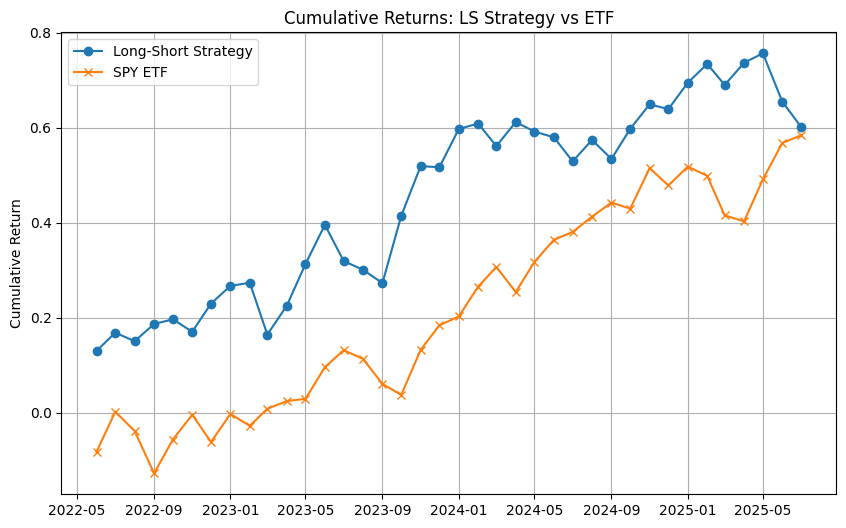

In [64]:
import yfinance as yf

# --- 1) Download ETF data ---
etf_ticker = "SPY"   # replace with your ETF, e.g. "NIFTYBEES.NS" for Indian Nifty 50 ETF
etf = yf.download(etf_ticker, start=df_model['date'].min(), end=df_model['date'].max(), auto_adjust=False)
etf['ret'] = etf['Adj Close']['SPY'].pct_change()

# --- 2) Convert ETF daily returns to monthly returns ---
etf['month'] = pd.to_datetime(etf.index).to_period('M')
etf_monthly = etf.groupby('month')['ret'].apply(lambda x: (1 + x).prod() - 1).to_frame('etf_ret')
etf_monthly.index = etf_monthly.index.to_timestamp()

# --- 3) Merge with strategy results ---
comparison = bt.join(etf_monthly, how='inner')

# --- 4) Compute cumulative returns ---
comparison['cum_etf'] = (1 + comparison['etf_ret']).cumprod() - 1

# --- 5) Compute performance metrics ---
def performance_metrics(returns, freq=12):
    mean_ret = returns.mean() * freq
    vol = returns.std() * (freq ** 0.5)
    sharpe = mean_ret / vol if vol != 0 else 0
    cum_ret = (1 + returns).prod() - 1
    return {
        "Ann. Return": mean_ret,
        "Ann. Volatility": vol,
        "Sharpe": sharpe,
        "Cumulative Return": cum_ret
    }

ls_metrics = performance_metrics(comparison['cum_ls'])
etf_metrics = performance_metrics(comparison['cum_etf'])

print("Long-Short Strategy Performance:")
for k, v in ls_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nETF Performance:")
for k, v in etf_metrics.items():
    print(f"{k}: {v:.4f}")

# --- 6) Plot comparison ---
plt.figure(figsize=(10,6))
plt.plot(comparison.index, comparison['cum_ls'], label="Long-Short Strategy", marker='o')
plt.plot(comparison.index, comparison['cum_etf'], label=f"{etf_ticker} ETF", marker='x')
plt.title("Cumulative Returns: LS Strategy vs ETF")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


=== Walk-Forward OOS (2015+) ===
Long/Short Strategy: {'Ann Return': np.float64(0.0243), 'Ann Vol': np.float64(0.0726), 'Sharpe': np.float64(0.3344), 'Max Drawdown': np.float64(-0.1724), 'CAGR': np.float64(0.0219)}
ETF Benchmark (SPY): {'Ann Return': np.float64(0.1293), 'Ann Vol': np.float64(0.1549), 'Sharpe': np.float64(0.8347), 'Max Drawdown': np.float64(-0.248), 'CAGR': np.float64(0.1239)}

Per-year summaries:
      Ann Return  Ann Vol  Sharpe  Max Drawdown    CAGR  months
year                                                           
2016     -0.0585   0.0597 -0.9799       -0.0331 -0.0586      12
2017      0.0049   0.0429  0.1131       -0.0392  0.0040      12
2018     -0.1532   0.0474 -3.2331       -0.1488 -0.1438      12
2019      0.0611   0.0388  1.5734       -0.0152  0.0621      12
2020      0.2673   0.0996  2.6824       -0.0294  0.2969      12
2021      0.0475   0.0678  0.7006       -0.0401  0.0464      12
2022     -0.0983   0.0943 -1.0425       -0.1423 -0.0978      12
2023   

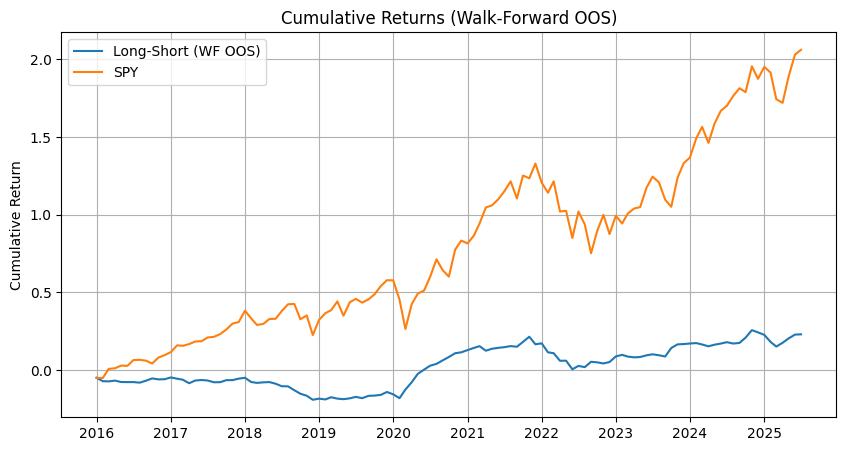

In [58]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import yfinance as yf

# --- config ---
start_year = 2015
embargo_days = 21          # prevent lookahead across split boundary
top_pct = 0.2              # long top 20%
bot_pct = 0.2              # short bottom 20%
etf_ticker = "SPY"         # benchmark ETF
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "seed": 42
}

# --- prepare data ---
df = df_model.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=model_cols + ['fwd_ret_21']).sort_values('date')

# helper: perf metrics on monthly returns
def perf_stats(rm, freq=12):
    ann_ret = rm.mean() * freq
    ann_vol = rm.std() * np.sqrt(freq)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    cum = (1 + rm).cumprod()
    peak = cum.cummax()
    dd = (cum / peak - 1)
    mdd = dd.min()
    # CAGR from monthly series
    years = len(rm) / freq
    cagr = cum.iloc[-1]**(1/years) - 1 if len(cum) else np.nan
    return {
        "Ann Return": ann_ret,
        "Ann Vol": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": mdd,
        "CAGR": cagr
    }

# pre-download ETF and convert to monthly returns
etf_px = yf.download(etf_ticker, start=df['date'].min(), end=df['date'].max(), auto_adjust=False)['Close']
etf_daily = etf_px.pct_change()
etf_monthly = etf_daily.groupby(etf_daily.index.to_period('M')).apply(lambda x: (1 + x).prod() - 1)
etf_monthly.index = etf_monthly.index.to_timestamp()
etf_monthly = etf_monthly.rename(columns={etf_monthly.columns[0]: 'etf_ret'})

# --- walk-forward backtest by test year ---
years = np.arange(start_year, df['date'].dt.year.max() + 1)
monthly_out = []      # list of dicts with month, ls_ret, year
fold_summaries = []   # per-year summaries

for test_year in years:
    # define test window = that calendar year
    test_mask = df['date'].dt.year == test_year
    if not test_mask.any():
        continue

    test_start = df.loc[test_mask, 'date'].min()
    train_end  = test_start - pd.Timedelta(days=embargo_days)
    train_mask = df['date'] < train_end

    if train_mask.sum() < 1000:   # not enough data to train
        continue

    # build train/test matrices; ensure numeric & aligned columns
    Xtr = df.loc[train_mask, model_cols].apply(pd.to_numeric, errors='coerce')
    ytr = df.loc[train_mask, 'fwd_ret_21']
    Xte = df.loc[test_mask,  model_cols].apply(pd.to_numeric, errors='coerce')
    yte = df.loc[test_mask,  'fwd_ret_21']

    # drop training columns with NaNs, align test to same set
    keep_cols = Xtr.columns[~Xtr.isna().any()]
    Xtr = Xtr[keep_cols]
    Xte = Xte[keep_cols].fillna(0)

    # fit and predict
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    model  = xgb.train(params, dtrain, num_boost_round=500,
                       evals=[(dtrain,'train')], early_stopping_rounds=30,
                       verbose_eval=False)
    preds = model.predict(xgb.DMatrix(Xte))

    fold = df.loc[test_mask, ['date','ticker','fwd_ret_21']].copy()
    fold['pred'] = preds
    fold['month'] = fold['date'].dt.to_period('M')

    # monthly long-short portfolio in the test year
    this_year_months = []
    for m, grp in fold.groupby('month'):
        grp = grp.dropna(subset=['pred','fwd_ret_21'])
        if len(grp) < 10:
            continue
        grp['rank_pct'] = grp['pred'].rank(pct=True)
        long_ret  = grp.loc[grp['rank_pct'] >= 1 - top_pct, 'fwd_ret_21'].mean()
        short_ret = grp.loc[grp['rank_pct'] <= bot_pct,     'fwd_ret_21'].mean()
        ls_ret = long_ret - short_ret
        this_year_months.append({'month': m.to_timestamp(), 'ls_ret': ls_ret, 'year': test_year})

    if not this_year_months:
        continue

    this_year_df = pd.DataFrame(this_year_months).set_index('month').sort_index()
    fold_summaries.append({
        'year': test_year,
        'months': len(this_year_df),
        **perf_stats(this_year_df['ls_ret'])
    })
    monthly_out.extend(this_year_months)

# --- stitch OOS monthly returns & compare to ETF ---
bt = pd.DataFrame(monthly_out).set_index('month').sort_index()
bt['cum_ls'] = (1 + bt['ls_ret']).cumprod() - 1

comp = bt[['ls_ret']].join(etf_monthly, how='inner')
comp['cum_etf'] = (1 + comp['etf_ret']).cumprod() - 1

# overall performance
ls_stats  = perf_stats(comp['ls_ret'])
etf_stats = perf_stats(comp['etf_ret'])

print("=== Walk-Forward OOS (2015+) ===")
print("Long/Short Strategy:", {k: round(v,4) for k,v in ls_stats.items()})
print("ETF Benchmark ({}):".format(etf_ticker), {k: round(v,4) for k,v in etf_stats.items()})

print("\nPer-year summaries:")
per_year = pd.DataFrame(fold_summaries).set_index('year')[['Ann Return','Ann Vol','Sharpe','Max Drawdown','CAGR','months']]
print(per_year.round(4))

comp['cum_ls'] = (1 + comp['ls_ret']).cumprod() - 1
# --- plots ---
plt.figure(figsize=(10,5))
plt.plot(comp.index, comp['cum_ls'], label='Long-Short (WF OOS)')
plt.plot(comp.index, comp['cum_etf'], label=f'{etf_ticker}')
plt.title('Cumulative Returns (Walk-Forward OOS)')
plt.ylabel('Cumulative Return')
plt.grid(True); plt.legend(); plt.show()


## Long only v1

[*********************100%***********************]  1 of 1 completed


=== Walk-Forward OOS (2015+) ===
Long-Only Strategy: {'Ann Return': np.float64(0.2104), 'Ann Vol': np.float64(0.1628), 'Sharpe': np.float64(1.2929), 'Sortino': np.float64(1.3447), 'Max Drawdown': np.float64(-0.2557), 'CAGR': np.float64(0.2155)}
ETF Benchmark (SPY): {'Ann Return': np.float64(0.1459), 'Ann Vol': np.float64(0.1537), 'Sharpe': np.float64(0.9494), 'Sortino': np.float64(1.3791), 'Max Drawdown': np.float64(-0.2393), 'CAGR': np.float64(0.1427)}

Per-year summaries:
      Ann Return  Ann Vol  Sharpe  Sortino  Max Drawdown    CAGR  months
year                                                                    
2016      0.2651   0.1058  2.5059   3.4935       -0.0104  0.2934      12
2017      0.3252   0.0614  5.2997      NaN        0.0000  0.3761      12
2018      0.0076   0.1227  0.0621   0.0847       -0.1358  0.0006      12
2019      0.2955   0.1149  2.5712   6.2009       -0.0309  0.3313      12
2020      0.4099   0.3392  1.2084   0.8418       -0.2484  0.4128      12
2021      

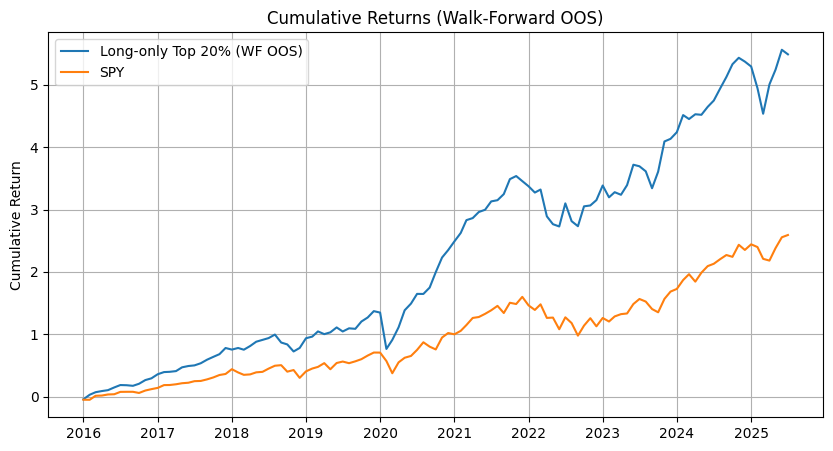

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import yfinance as yf


# --- config ---
start_year = 2015
embargo_days = 21          # prevent lookahead across split boundary
top_pct = 0.2              # long top 20%
etf_ticker = "SPY"         # benchmark ETF
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "seed": 42
}

# --- prepare data ---
df = df_model.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=model_cols + ['fwd_ret_21']).sort_values('date')

# helper: perf metrics on monthly returns
def perf_stats(rm, freq=12):
    ann_ret = rm.mean() * freq
    ann_vol = rm.std() * np.sqrt(freq)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    cum = (1 + rm).cumprod()
    peak = cum.cummax()
    dd = (cum / peak - 1)
    mdd = dd.min()
    # CAGR
    years = len(rm) / freq
    cagr = cum.iloc[-1]**(1/years) - 1 if len(cum) else np.nan
    # Sortino (downside risk)
    downside = rm[rm < 0].std() * np.sqrt(freq)
    sortino = ann_ret / downside if downside != 0 else np.nan
    
    return {
        "Ann Return": ann_ret,
        "Ann Vol": ann_vol,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "Max Drawdown": mdd,
        "CAGR": cagr
    }


# pre-download ETF and convert to monthly returns
etf_px = yf.download(etf_ticker, start=df['date'].min(), end=df['date'].max(), auto_adjust=False)['Adj Close']
etf_daily = etf_px.pct_change()
etf_monthly = etf_daily.groupby(etf_daily.index.to_period('M')).apply(lambda x: (1 + x).prod() - 1)
etf_monthly.index = etf_monthly.index.to_timestamp()
etf_monthly = etf_monthly.rename(columns={etf_monthly.columns[0]: 'etf_ret'})

# --- walk-forward backtest by test year ---
years = np.arange(start_year, df['date'].dt.year.max() + 1)
monthly_out = []      # list of dicts with month, long_ret, year
fold_summaries = []   # per-year summaries

for test_year in years:
    # define test window = that calendar year
    test_mask = df['date'].dt.year == test_year
    if not test_mask.any():
        continue

    test_start = df.loc[test_mask, 'date'].min()
    train_end  = test_start - pd.Timedelta(days=embargo_days)
    train_mask = df['date'] < train_end

    if train_mask.sum() < 1000:   # not enough data to train
        continue

    # build train/test matrices
    Xtr = df.loc[train_mask, model_cols].apply(pd.to_numeric, errors='coerce')
    ytr = df.loc[train_mask, 'fwd_ret_21']
    Xte = df.loc[test_mask,  model_cols].apply(pd.to_numeric, errors='coerce')
    yte = df.loc[test_mask,  'fwd_ret_21']

    # drop training columns with NaNs, align test to same set
    keep_cols = Xtr.columns[~Xtr.isna().any()]
    Xtr = Xtr[keep_cols]
    Xte = Xte[keep_cols].fillna(0)

    # fit and predict
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    model  = xgb.train(params, dtrain, num_boost_round=500,
                       evals=[(dtrain,'train')], early_stopping_rounds=30,
                       verbose_eval=False)
    preds = model.predict(xgb.DMatrix(Xte))

    fold = df.loc[test_mask, ['date','ticker','fwd_ret_21']].copy()
    fold['pred'] = preds
    fold['month'] = fold['date'].dt.to_period('M')

    # monthly long-only portfolio in the test year
    this_year_months = []
    for m, grp in fold.groupby('month'):
        grp = grp.dropna(subset=['pred','fwd_ret_21'])
        if len(grp) < 10:
            continue
        grp['rank_pct'] = grp['pred'].rank(pct=True)
        # long only top 20%
        long_ret = grp.loc[grp['rank_pct'] >= 1 - top_pct, 'fwd_ret_21'].mean()
        this_year_months.append({'month': m.to_timestamp(), 'long_ret': long_ret, 'year': test_year})

    if not this_year_months:
        continue

    this_year_df = pd.DataFrame(this_year_months).set_index('month').sort_index()
    fold_summaries.append({
        'year': test_year,
        'months': len(this_year_df),
        **perf_stats(this_year_df['long_ret'])
    })
    monthly_out.extend(this_year_months)

# --- stitch OOS monthly returns & compare to ETF ---
bt = pd.DataFrame(monthly_out).set_index('month').sort_index()
bt['cum_long'] = (1 + bt['long_ret']).cumprod() - 1

comp = bt.join(etf_monthly, how='inner')
comp['cum_etf'] = (1 + comp['etf_ret']).cumprod() - 1

# overall performance
long_stats = perf_stats(comp['long_ret'])
etf_stats  = perf_stats(comp['etf_ret'])

print("=== Walk-Forward OOS (2015+) ===")
print("Long-Only Strategy:", {k: round(v,4) for k,v in long_stats.items()})
print("ETF Benchmark ({}):".format(etf_ticker), {k: round(v,4) for k,v in etf_stats.items()})

print("\nPer-year summaries:")
per_year = pd.DataFrame(fold_summaries).set_index('year')[['Ann Return','Ann Vol','Sharpe','Sortino','Max Drawdown','CAGR','months']]
print(per_year.round(4))

# --- plots ---
plt.figure(figsize=(10,5))
plt.plot(comp.index, comp['cum_long'], label='Long-only Top 20% (WF OOS)')
plt.plot(comp.index, comp['cum_etf'], label=f'{etf_ticker}')
plt.title('Cumulative Returns (Walk-Forward OOS)')
plt.ylabel('Cumulative Return')
plt.grid(True); plt.legend(); plt.show()


=== Walk-Forward OOS (2015+) with Turnover & Costs ===
Gross (no costs): {'Ann Return': np.float64(0.2104), 'Ann Vol': np.float64(0.1628), 'Sharpe': np.float64(1.2929), 'Sortino': np.float64(1.3447), 'Max Drawdown': np.float64(-0.2557), 'CAGR': np.float64(0.2155)}
Net (after costs): {'Ann Return': np.float64(0.2089), 'Ann Vol': np.float64(0.1628), 'Sharpe': np.float64(1.2833), 'Sortino': np.float64(1.3346), 'Max Drawdown': np.float64(-0.2558), 'CAGR': np.float64(0.2136)}
ETF (SPY): {'Ann Return': np.float64(0.1459), 'Ann Vol': np.float64(0.1537), 'Sharpe': np.float64(0.9494), 'Sortino': np.float64(1.3791), 'Max Drawdown': np.float64(-0.2393), 'CAGR': np.float64(0.1427)}

Avg monthly turnover: 0.363
Median monthly turnover: 0.385
Avg monthly cost (decimal): 0.000131   (~bps: 1.31 )

Per-year (NET) summaries:
      Ann Return  Ann Vol  Sharpe  Sortino  Max Drawdown    CAGR  months
year                                                                    
2016      0.2631   0.1057  2.4887  

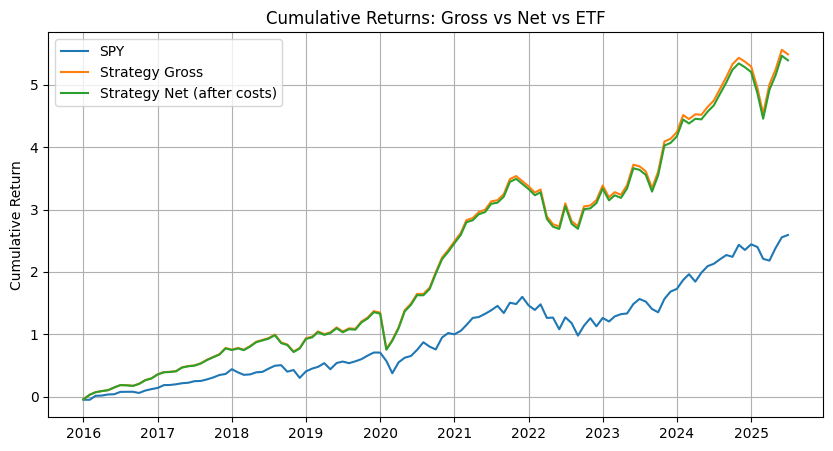

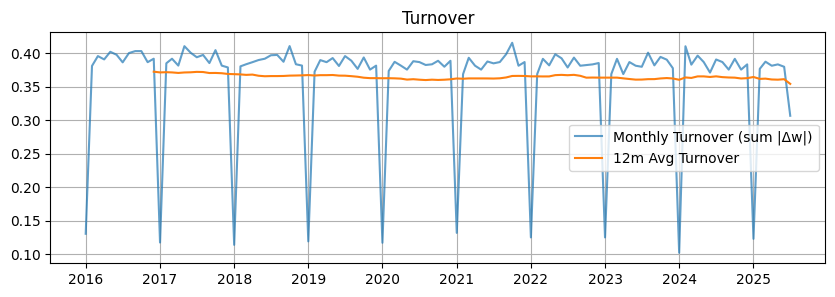

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import yfinance as yf

# --- config (costs; low-cost big fund assumptions) ---
commission_bps   = 0.2    # per $ traded
half_spread_bps  = 1.0    # per $ traded (effective)
use_impact       = True  # set True if adv_21 available in df_model
AUM              = 1_000_000_000  # $1B (only needed if use_impact=True)
impact_coef      = 12.0   # scale for square-root impact (tune as needed)

# --- wf config (same as your long-only code) ---
start_year   = 2015
embargo_days = 21
top_pct      = 0.2
etf_ticker   = "SPY"
params = {"objective":"reg:squarederror","learning_rate":0.05,"max_depth":4,
          "subsample":0.8,"colsample_bytree":0.6,"seed":42}

# --- data prep (same as yours) ---
df = df_model.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=model_cols + ['fwd_ret_21']).sort_values('date')

# ETF monthly total return
etf_px = yf.download(etf_ticker, start=df['date'].min(), end=df['date'].max(),
                     auto_adjust=False, progress=False)['Adj Close']
etf_daily = etf_px.pct_change()
etf_monthly = etf_daily.groupby(etf_daily.index.to_period('M')).apply(lambda x: (1+x).prod()-1)
etf_monthly.index = etf_monthly.index.to_timestamp()
etf_monthly = etf_monthly.rename(columns={etf_monthly.columns[0]: 'etf_ret'})

def perf_stats(rm, freq=12):
    ann_ret = rm.mean()*freq
    ann_vol = rm.std()*np.sqrt(freq)
    sharpe  = ann_ret/ann_vol if ann_vol!=0 else np.nan
    cum = (1+rm).cumprod(); peak=cum.cummax()
    mdd = (cum/peak - 1).min()
    years = len(rm)/freq
    cagr = cum.iloc[-1]**(1/years)-1 if len(cum) else np.nan
    # Sortino
    dstd = rm[rm<0].std()*np.sqrt(freq)
    sortino = ann_ret/dstd if dstd and not np.isclose(dstd,0) else np.nan
    return {"Ann Return":ann_ret,"Ann Vol":ann_vol,"Sharpe":sharpe,"Sortino":sortino,"Max Drawdown":mdd,"CAGR":cagr}

years = np.arange(start_year, df['date'].dt.year.max()+1)
monthly_out = []   # will hold month, long_ret_gross, turnover, cost_rate, long_ret_net
fold_summaries = []

for test_year in years:
    test_mask = df['date'].dt.year == test_year
    if not test_mask.any(): 
        continue
    test_start = df.loc[test_mask,'date'].min()
    train_end  = test_start - pd.Timedelta(days=embargo_days)
    train_mask = df['date'] < train_end
    if train_mask.sum() < 1000:
        continue

    # Train & predict
    Xtr = df.loc[train_mask, model_cols].apply(pd.to_numeric, errors='coerce')
    ytr = df.loc[train_mask, 'fwd_ret_21']
    Xte = df.loc[test_mask,  model_cols].apply(pd.to_numeric, errors='coerce')
    yte = df.loc[test_mask,  'fwd_ret_21']
    keep_cols = Xtr.columns[~Xtr.isna().any()]
    Xtr, Xte = Xtr[keep_cols], Xte[keep_cols].fillna(0)

    dtrain = xgb.DMatrix(Xtr, label=ytr)
    model  = xgb.train(params, dtrain, num_boost_round=500,
                       evals=[(dtrain,'train')], early_stopping_rounds=30,
                       verbose_eval=False)
    preds = model.predict(xgb.DMatrix(Xte))

    # Build fold DF with any aux fields we might need
    cols = ['date','ticker','fwd_ret_21']
    for extra in ['adv_21','vol_21','close','volume']:
        if extra in df.columns: cols.append(extra)
    fold = df.loc[test_mask, cols].copy()
    fold['pred']  = preds
    fold['month'] = fold['date'].dt.to_period('M')

    # Iterate months; compute turnover & costs
    prev_weights = None
    prev_month   = None
    prev_realized = None  # dict of realized r for prev month (to drift weights)

    this_year = []

    for m, grp in fold.groupby('month'):
        # --- (inside your monthly loop) ---

        grp = grp.copy()
        # 1) PURE selection (exactly as before)
        grp['rank_pct'] = grp['pred'].rank(pct=True, method='first')  # method fixed for tie consistency
        sel = grp[grp['rank_pct'] >= 1 - top_pct]                     # top 20%
        long_names = sel['ticker'].tolist()

        # 2) GROSS return computed ONLY from selection above
        long_ret = sel['fwd_ret_21'].mean()   # <-- gross is locked here

        # 3) Build target weights from the SAME selection (equal-weight)
        n = len(long_names)
        w_target = {t: 1.0/n for t in long_names} if n > 0 else {}

        # 4) Pre-trade drifted weights (for turnover only) — does not affect selection
        if prev_weights is None:
            w_pre = {t: 0.0 for t in long_names}
        else:
            w_temp = {t: prev_weights.get(t, 0.0) * (1.0 + prev_realized.get(t, 0.0))
                    for t in prev_weights}
            total = sum(w_temp.values())
            if total > 0:
                for t in w_temp: w_temp[t] /= total
            union = set(w_temp) | set(w_target)
            w_pre = {t: w_temp.get(t, 0.0) for t in union}

        # 5) Turnover = 0.5 * L1 change (fix double-count)
        diffs = {t: w_target.get(t,0.0) - w_pre.get(t,0.0) for t in (set(w_pre)|set(w_target))}
        turnover = 0.5 * sum(abs(d) for d in diffs.values())

        # 6) Costs (do NOT change selection)
        base_bps   = commission_bps + half_spread_bps
        impact_bps = 0.0
        if use_impact and 'adv_21' in grp.columns:
            adv_map = grp.set_index('ticker')['adv_21'].to_dict()
            total_abs = sum(abs(d) for d in diffs.values()) or 1e-12
            for t, d in diffs.items():
                adv = adv_map.get(t, np.nan)
                if np.isfinite(adv) and adv > 0:
                    dollars = abs(d) * AUM
                    pr = min(1.0, dollars / adv)
                    impact_bps += (impact_coef * np.sqrt(pr)) * (abs(d)/total_abs)

        cost_rate = turnover * ((base_bps + impact_bps) / 1e4)
        net_ret   = long_ret - cost_rate

        # 7) Save + prep next month (realized returns to drift)
        this_year.append({'month': m.to_timestamp(),
                        'long_ret': long_ret,
                        'turnover': turnover,
                        'cost_rate': cost_rate,
                        'long_ret_net': net_ret})
        prev_weights  = w_target
        prev_realized = grp.set_index('ticker')['fwd_ret_21'].to_dict()


    if not this_year:
        continue

    year_df = pd.DataFrame(this_year).set_index('month').sort_index()
    # per-year summary on NET returns
    fold_summaries.append({'year': test_year, 'months': len(year_df),
                           **perf_stats(year_df['long_ret_net'])})
    monthly_out.extend(this_year)

# --- Stitch OOS & compare to ETF ---
bt = pd.DataFrame(monthly_out).set_index('month').sort_index()
bt['cum_long_gross'] = (1 + bt['long_ret']).cumprod() - 1
bt['cum_long_net']   = (1 + bt['long_ret_net']).cumprod() - 1
bt['avg_turnover_12m'] = bt['turnover'].rolling(12).mean()

comp = bt[['long_ret','long_ret_net']].join(etf_monthly, how='inner')
comp['cum_etf'] = (1 + comp['etf_ret']).cumprod() - 1

gross_stats = perf_stats(comp['long_ret'])
net_stats   = perf_stats(comp['long_ret_net'])
etf_stats   = perf_stats(comp['etf_ret'])

print("=== Walk-Forward OOS (2015+) with Turnover & Costs ===")
print("Gross (no costs):", {k: round(v,4) for k,v in gross_stats.items()})
print("Net (after costs):", {k: round(v,4) for k,v in net_stats.items()})
print(f"ETF ({etf_ticker}):", {k: round(v,4) for k,v in etf_stats.items()})
print("\nAvg monthly turnover:", bt['turnover'].mean().round(4))
print("Median monthly turnover:", bt['turnover'].median().round(4))
print("Avg monthly cost (decimal):", bt['cost_rate'].mean().round(6), "  (~bps:", (bt['cost_rate'].mean()*1e4).round(2), ")")

per_year = pd.DataFrame(fold_summaries).set_index('year')[['Ann Return','Ann Vol','Sharpe','Sortino','Max Drawdown','CAGR','months']]
print("\nPer-year (NET) summaries:")
print(per_year.round(4))

# --- Plots ---
plt.figure(figsize=(10,5))
plt.plot(comp.index, comp['cum_etf'],      label=f'{etf_ticker}')
plt.plot(bt.index,   bt['cum_long_gross'], label='Strategy Gross')
plt.plot(bt.index,   bt['cum_long_net'],   label='Strategy Net (after costs)')
plt.title('Cumulative Returns: Gross vs Net vs ETF')
plt.ylabel('Cumulative Return'); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(bt.index, bt['turnover'], alpha=0.7, label='Monthly Turnover (sum |Δw|)')
plt.plot(bt.index, bt['avg_turnover_12m'], label='12m Avg Turnover')
plt.title('Turnover'); plt.legend(); plt.grid(True); plt.show()


## Cost Sensitivity Analysis

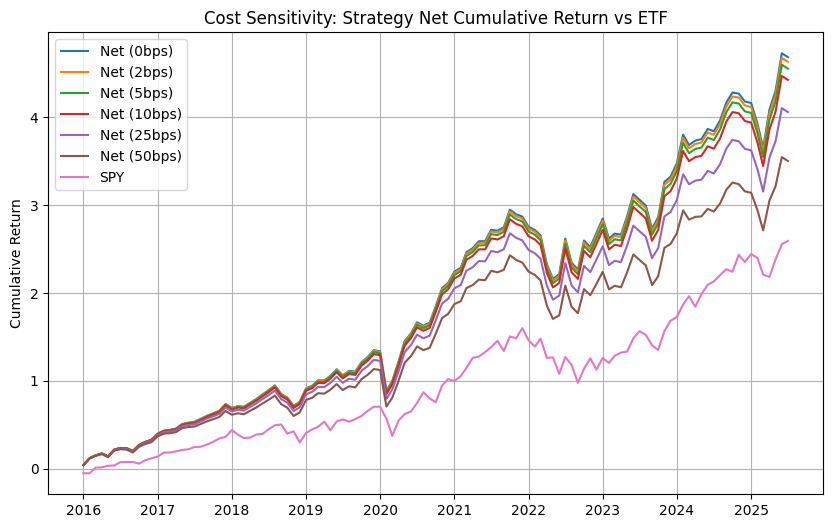


=== Net Performance vs Cost Assumptions (monthly returns) ===
              CAGR  Ann Return  Ann Vol  Sharpe  Sortino  Max DD
Cost (bps)                                                      
0           0.1988      0.1946   0.1539  1.2642   1.5793 -0.1995
2           0.1976      0.1936   0.1539  1.2577   1.5712 -0.1999
5           0.1959      0.1921   0.1539  1.2481   1.5589 -0.2007
10          0.1930      0.1896   0.1539  1.2320   1.5451 -0.2018
25          0.1843      0.1823   0.1540  1.1838   1.4839 -0.2053
50          0.1700      0.1699   0.1540  1.1034   1.3820 -0.2112

ETF (SPY) stats: {'CAGR': np.float64(0.1427), 'Ann Return': np.float64(0.1459), 'Ann Vol': np.float64(0.1537), 'Sharpe': np.float64(0.9494), 'Sortino': np.float64(1.3791), 'Max DD': np.float64(-0.2393)}


In [48]:
# === Cost Sensitivity (uses your bt['long_ret'] and bt['turnover']) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# join to ensure common monthly index with ETF
comp_base = bt[['long_ret','turnover']].join(etf_monthly, how='inner')  # etf_monthly['etf_ret']

# cost grid in bps per $ traded (commission + half-spread + slippage, etc.)
cost_grid_bps = [0, 2, 5, 10, 25, 50]  # tweak as you like

def perf_stats(rm, freq=12):
    ann_ret = rm.mean() * freq
    ann_vol = rm.std() * np.sqrt(freq)
    sharpe  = ann_ret / ann_vol if ann_vol != 0 else np.nan
    cum = (1 + rm).cumprod(); peak = cum.cummax()
    mdd = (cum/peak - 1).min()
    years = len(rm)/freq
    cagr = cum.iloc[-1]**(1/years) - 1 if len(cum) else np.nan
    dstd = rm[rm < 0].std() * np.sqrt(freq)
    sortino = ann_ret / dstd if (dstd is not None and not np.isclose(dstd,0)) else np.nan
    return {"CAGR": cagr, "Ann Return": ann_ret, "Ann Vol": ann_vol, "Sharpe": sharpe, "Sortino": sortino, "Max DD": mdd}

# build net return series for each cost level
curves = {}
stats_rows = []

for bps in cost_grid_bps:
    cost_per_dollar = bps / 1e4  # decimal
    net_ret = comp_base['long_ret'] - comp_base['turnover'] * cost_per_dollar
    curves[f'Net ({bps}bps)'] = (1 + net_ret).cumprod() - 1
    s = perf_stats(net_ret)
    s['Cost (bps)'] = bps
    stats_rows.append(s)

# Benchmark curve
curves[f'{etf_ticker}'] = (1 + comp_base['etf_ret']).cumprod() - 1

# --- Plot cumulative curves ---
plt.figure(figsize=(10,6))
for label, curve in curves.items():
    plt.plot(curve.index, curve.values, label=label)
plt.title('Cost Sensitivity: Strategy Net Cumulative Return vs ETF')
plt.ylabel('Cumulative Return')
plt.grid(True); plt.legend(); plt.show()

# --- Metrics table ---
stats_df = pd.DataFrame(stats_rows).set_index('Cost (bps)').sort_index()
print("\n=== Net Performance vs Cost Assumptions (monthly returns) ===")
print(stats_df.round(4))

# Optional: add ETF metrics for reference
etf_stats = perf_stats(comp_base['etf_ret'])
print(f"\nETF ({etf_ticker}) stats:", {k: round(v,4) for k,v in etf_stats.items()})


## Rolling Sharpe and Sortino

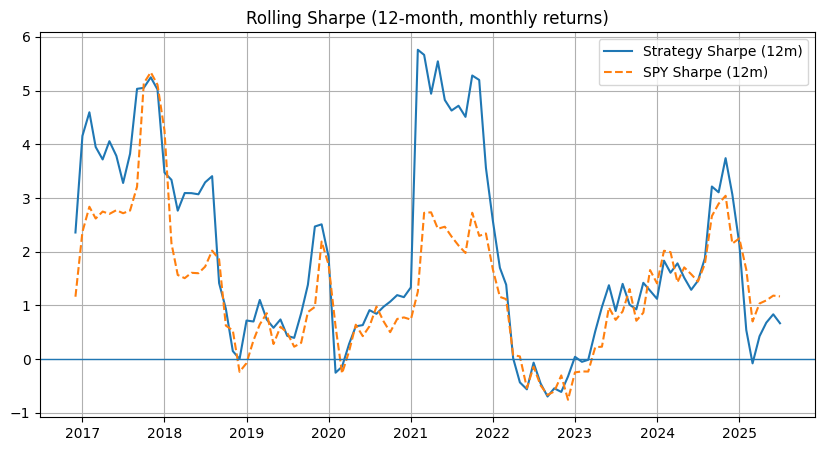

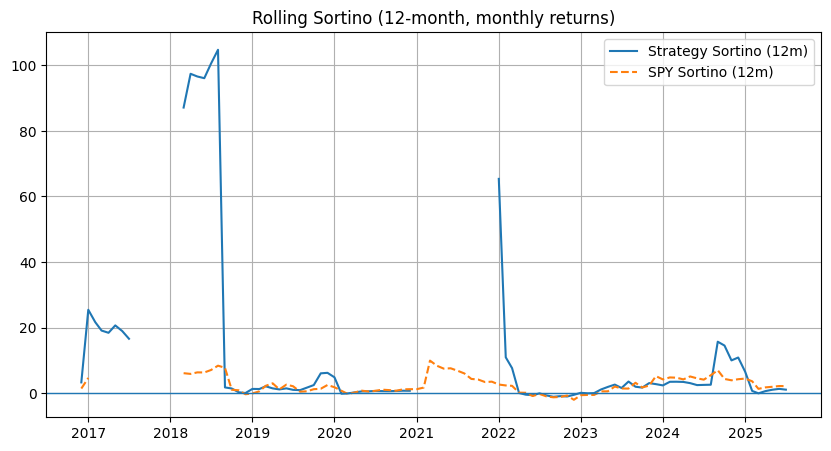

In [ ]:
# --- Rolling Sharpe & Sortino on MONTHLY returns (use comp['long_ret'] and comp['etf_ret']) ---

import numpy as np
import matplotlib.pyplot as plt

def rolling_sharpe(r, window=12, freq=12):
    # r is a monthly return Series
    return r.rolling(window).apply(
        lambda x: (x.mean() / x.std(ddof=1)) * np.sqrt(freq) if x.std(ddof=1) not in (0, np.nan) else np.nan,
        raw=False
    )

def rolling_sortino(r, window=12, freq=12):
    def _sortino(x):
        neg = x[x < 0]
        if len(neg) < 2 or np.isclose(neg.std(ddof=1), 0, equal_nan=True):
            return np.nan
        return (x.mean() / neg.std(ddof=1)) * np.sqrt(freq)
    return r.rolling(window).apply(_sortino, raw=False)

# Compute rolling metrics
roll_sharpe_long   = rolling_sharpe(comp['long_ret'], window=12, freq=12)
roll_sharpe_etf    = rolling_sharpe(comp['etf_ret'],  window=12, freq=12)
roll_sortino_long  = rolling_sortino(comp['long_ret'], window=12, freq=12)
roll_sortino_etf   = rolling_sortino(comp['etf_ret'],  window=12, freq=12)

# Plot rolling Sharpe
plt.figure(figsize=(10,5))
plt.plot(roll_sharpe_long.index, roll_sharpe_long, label='Strategy Sharpe (12m)')
plt.plot(roll_sharpe_etf.index,  roll_sharpe_etf,  label=f'{etf_ticker} Sharpe (12m)', linestyle='--')
plt.axhline(0, linewidth=1)
plt.title('Rolling Sharpe (12-month, monthly returns)')
plt.legend(); plt.grid(True); plt.show()

# Plot rolling Sortino
plt.figure(figsize=(10,5))
plt.plot(roll_sortino_long.index, roll_sortino_long, label='Strategy Sortino (12m)')
plt.plot(roll_sortino_etf.index,  roll_sortino_etf,  label=f'{etf_ticker} Sortino (12m)', linestyle='--')
plt.axhline(0, linewidth=1)
plt.title('Rolling Sortino (12-month, monthly returns)')
plt.legend(); plt.grid(True); plt.show()


## Factor Attribution

In [7]:
%pip install statsmodels
import statsmodels.api as sm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


                            OLS Regression Results                            
Dep. Variable:               long_ret   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     8.116
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           9.12e-06
Time:                        21:00:47   Log-Likelihood:                 201.91
No. Observations:                 114   AIC:                            -393.8
Df Residuals:                     109   BIC:                            -380.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.004      2.597      0.0

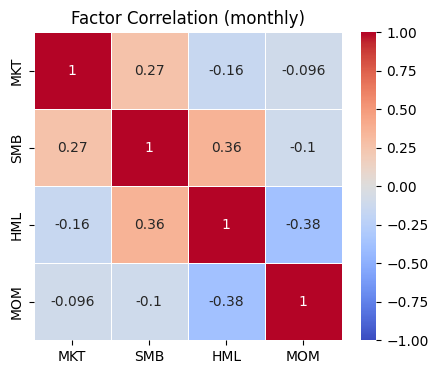

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1) Build monthly factor returns from ETF proxies (total-return)
factor_tickers = ["SPY", "IWM", "IVE", "IVW", "MTUM"]

px = yf.download(
    factor_tickers,
    start=comp.index.min(), end=comp.index.max(),
    auto_adjust=True, progress=False
)["Close"]

# daily -> monthly total returns
dret = px.pct_change()
mret = dret.groupby(dret.index.to_period("M")).apply(lambda x: (1 + x).prod() - 1)
mret.index = mret.index.to_timestamp()

# factors (no RF subtraction; consistent with your CAPM that used SPY directly)
factors_df = pd.DataFrame({
    "MKT": mret["SPY"],
    "SMB": mret["IWM"] - mret["SPY"],
    "HML": mret["IVE"] - mret["IVW"],
    "MOM": mret["MTUM"] - mret["SPY"],
}).dropna()

# 2) Align with strategy monthly returns (comp['long_ret'])
aligned = comp[["long_ret"]].join(factors_df, how="inner").dropna()

# 3) Run multi-factor regression (time-series attribution)
X = sm.add_constant(aligned[["MKT","SMB","HML","MOM"]])
y = aligned["long_ret"]

ols = sm.OLS(y, X).fit()
print(ols.summary())

# Optional: Newey-West (HAC) robust t-stats (handles autocorr/heterosked.)
ols_hac = ols.get_robustcov_results(cov_type="HAC", maxlags=12)
print("\n=== Newey–West (12-lag) robust ===")
print(ols_hac.summary())

# 4) Factor contributions (monthly and annualized)
betas = ols.params[["MKT","SMB","HML","MOM"]]
alpha_m = ols.params["const"]
avg_factor_rets = aligned[["MKT","SMB","HML","MOM"]].mean()

monthly_contrib = betas * avg_factor_rets
annual_contrib = monthly_contrib * 12
alpha_annual = alpha_m * 12

print("\nMonthly factor contributions:")
print(monthly_contrib.round(6))
print("\nAnnualized factor contributions:")
print(annual_contrib.round(4))
print(f"\nAnnualized alpha: {alpha_annual:.4f}")

# 5) Quick visuals
import seaborn as sns

corr = aligned[["MKT","SMB","HML","MOM"]].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1,
            linewidths=0.5, square=True, cbar=True)
plt.title("Factor Correlation (monthly)")
plt.show()



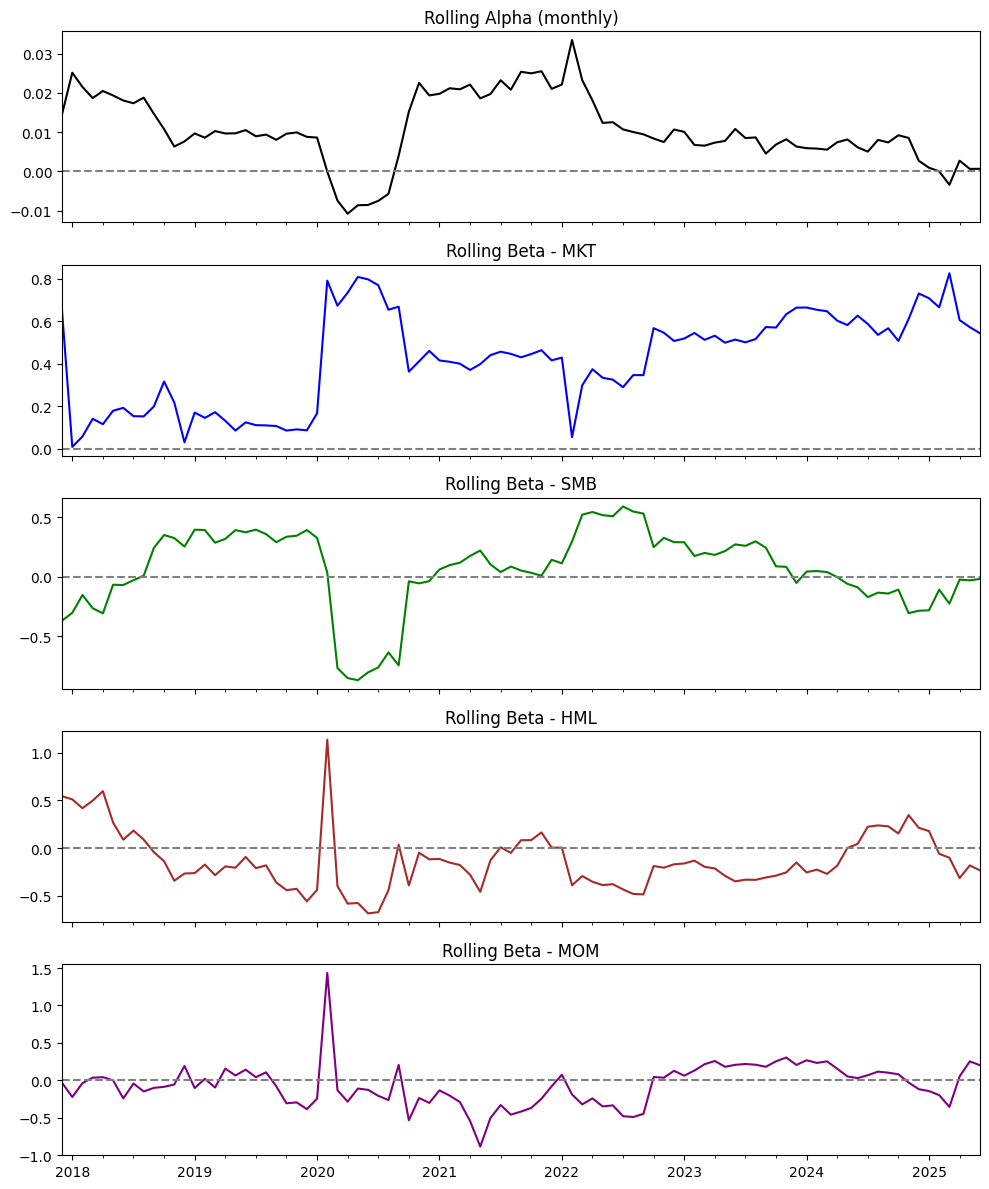

In [10]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# --- Data assumption ---
# aligned = DataFrame with columns ["long_ret","MKT","SMB","HML","MOM"]
# all monthly frequency, aligned index (DatetimeIndex)

# --- Rolling regression (e.g., 24-month window) ---
window = 24
betas = []

for start in range(len(aligned) - window + 1):
    sub = aligned.iloc[start:start+window]
    y = sub['long_ret']
    X = sub[['MKT','SMB','HML','MOM']]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    betas.append(model.params)

rolling_betas = pd.DataFrame(betas, index=aligned.index[window-1:])

# --- Plot exposures ---
fig, ax = plt.subplots(5,1, figsize=(10,12), sharex=True)

rolling_betas['const'].plot(ax=ax[0], title="Rolling Alpha (monthly)", color='black')
ax[0].axhline(0, ls='--', color='grey')

rolling_betas['MKT'].plot(ax=ax[1], title="Rolling Beta - MKT", color='blue')
ax[1].axhline(0, ls='--', color='grey')

rolling_betas['SMB'].plot(ax=ax[2], title="Rolling Beta - SMB", color='green')
ax[2].axhline(0, ls='--', color='grey')

rolling_betas['HML'].plot(ax=ax[3], title="Rolling Beta - HML", color='brown')
ax[3].axhline(0, ls='--', color='grey')

rolling_betas['MOM'].plot(ax=ax[4], title="Rolling Beta - MOM", color='purple')
ax[4].axhline(0, ls='--', color='grey')

plt.tight_layout()
plt.show()


## Long only v2

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's ndcg@1: 0.537037	valid_0's ndcg@2: 0.587185	valid_0's ndcg@3: 0.61887	valid_0's ndcg@4: 0.561523	valid_0's ndcg@5: 0.56074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's ndcg@1: 0.481481	valid_0's ndcg@2: 0.467154	valid_0's ndcg@3: 0.44879	valid_0's ndcg@4: 0.429378	valid_0's ndcg@5: 0.424066
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's ndcg@1: 0.611111	valid_0's ndcg@2: 0.51798	valid_0's ndcg@3: 0.587629	valid_0's ndcg@4: 0.582237	valid_0's ndcg@5: 0.573876
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5]	valid_0's ndcg@1: 0.537037	valid_0's ndcg@2: 0.551365	valid_0's ndcg@3: 0.534968	valid_0's ndcg@4: 0.510408	valid_0's ndcg@5: 0.484745
Training until validation scores don't improve for 100 roun

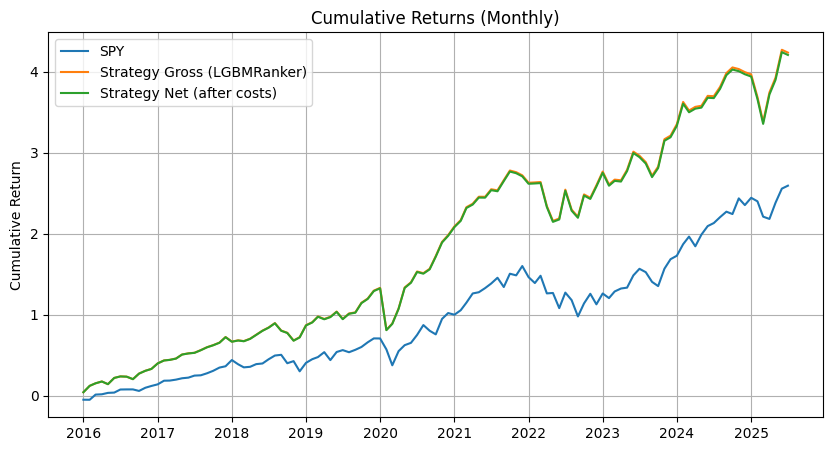

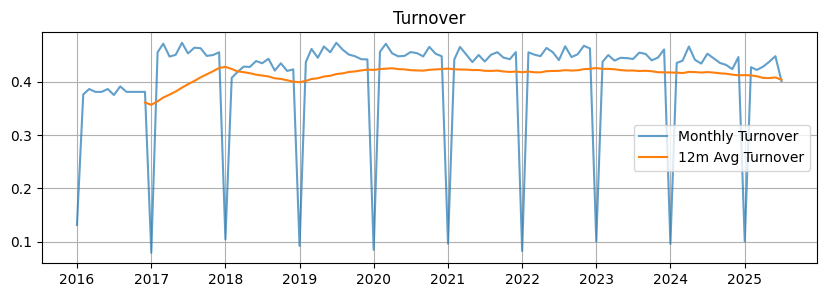

In [49]:
# =========================
# LightGBM Ranker — Long-only v2 (Walk-Forward, Monthly)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

# ---- LightGBM import ----
try:
    import lightgbm as lgb
except ImportError as e:
    raise ImportError("LightGBM not installed. Run: pip install lightgbm") from e

# ---- Config ----
RNG_SEED      = 42
START_YEAR    = 2015
EMBARGO_DAYS  = 21            # avoid target overlap across split boundary
TOP_PCT       = 0.20          # long-only top 20%
ETF_TICKER    = "SPY"
# IMPORTANT: features built on raw Close -> keep benchmark on raw Close too
ETF_AUTO_ADJ  = False         # False => price-only (Close), consistent with your features

# Transaction cost assumptions (low-cost 'big fund')
COMMISSION_BPS  = 0.2
HALF_SPREAD_BPS = 1.0

np.random.seed(RNG_SEED)

# ---- Helpers ----
def month_end_mask(dates: pd.Series) -> pd.Series:
    d = pd.to_datetime(dates)
    return d == d.groupby(d.dt.to_period("M")).transform("max")

def groups_by_date(dates: pd.Series) -> np.ndarray:
    d = pd.to_datetime(dates)
    return d.value_counts().sort_index().values.astype(int)

def safe_numeric(df: pd.DataFrame) -> pd.DataFrame:
    return df.apply(pd.to_numeric, errors="coerce")

def perf_stats(rm: pd.Series, freq: int = 12) -> dict:
    rm = rm.dropna()
    if rm.empty:
        return {"Ann Return":np.nan,"Ann Vol":np.nan,"Sharpe":np.nan,"Sortino":np.nan,"Max Drawdown":np.nan,"CAGR":np.nan}
    ann_ret = rm.mean()*freq
    ann_vol = rm.std(ddof=1)*np.sqrt(freq)
    sharpe  = ann_ret/ann_vol if ann_vol else np.nan
    dstd    = rm[rm<0].std(ddof=1)*np.sqrt(freq)
    sortino = ann_ret/dstd if dstd else np.nan
    cum = (1+rm).cumprod()
    mdd = (cum/cum.cummax()-1).min()
    years = len(rm)/freq
    cagr = cum.iloc[-1]**(1/years)-1 if years>0 else np.nan
    return {"Ann Return":ann_ret,"Ann Vol":ann_vol,"Sharpe":sharpe,"Sortino":sortino,"Max Drawdown":mdd,"CAGR":cagr}

def monthify(daily_ret: pd.Series) -> pd.Series:
    out = daily_ret.groupby(daily_ret.index.to_period("M")).apply(lambda x: (1+x).prod()-1)
    return out.set_axis(out.index.to_timestamp())

LEVELS = 11  # 0..30

def make_relevance_per_month(y: pd.Series, dates: pd.Series, levels: int = LEVELS) -> pd.Series:
    # higher y => higher relevance level
    def to_levels(v: pd.Series) -> pd.Series:
        r = v.rank(method='first')              # 1..n
        pct = (r - 1) / (len(r) - 1 + 1e-9)    # 0..1
        rel = np.floor(pct * (levels - 1)).astype(int)  # 0..levels-1
        return rel
    return y.groupby(pd.to_datetime(dates)).transform(to_levels).astype(int)


# =========================
# Data prep (assumes df_model & model_cols exist from your feature step)
# =========================
df = df_model.copy()
assert set(["date","ticker","fwd_ret_21"]).issubset(df.columns), "df_model must include date,ticker,fwd_ret_21"
assert set(model_cols).issubset(df.columns), "model_cols missing from df_model"

df["date"] = pd.to_datetime(df["date"])
df = df.dropna(subset=model_cols+["fwd_ret_21"]).sort_values("date")

# ETF monthly (price-only to match features)
etf_close = yf.download(ETF_TICKER, start=df["date"].min(), end=df["date"].max(),
                        auto_adjust=ETF_AUTO_ADJ, progress=False)["Adj Close"]['SPY']
etf_monthly = monthify(etf_close.pct_change().dropna()).to_frame(name="etf_ret")

# =========================
# Walk-Forward with LGBMRanker (lambdarank)
# =========================
years = np.arange(START_YEAR, df["date"].dt.year.max()+1)
monthly_out = []
per_year = []

for test_year in years:
    test_mask  = df["date"].dt.year == test_year
    if not test_mask.any():
        continue

    test_start = df.loc[test_mask, "date"].min()
    train_end  = test_start - pd.Timedelta(days=EMBARGO_DAYS)
    train_mask = df["date"] < train_end
    if train_mask.sum() < 1000:
        continue

    # Build train/test frames
    Xtr_full = safe_numeric(df.loc[train_mask, model_cols])
    ytr_full = df.loc[train_mask, 'fwd_ret_21']
    Dtr      = df.loc[train_mask, ['date']].copy()

    Xte = safe_numeric(df.loc[test_mask, model_cols]).fillna(0)
    yte = df.loc[test_mask, 'fwd_ret_21']

    keep_cols = Xtr_full.columns[~Xtr_full.isna().any()]  # drop any NaN cols
    Xtr_full, Xte = Xtr_full[keep_cols], Xte[keep_cols]

    # month-end rows for training
    me_mask_tr = month_end_mask(df.loc[train_mask, 'date'])
    Xtr = Xtr_full.loc[me_mask_tr].copy()
    ytr = ytr_full.loc[me_mask_tr].copy()
    dtr = Dtr.loc[me_mask_tr, 'date']

    # integer relevance 0..30
    ytr_rel = make_relevance_per_month(ytr, dtr, levels=LEVELS)

    group_sizes = groups_by_date(dtr)

    ranker = lgb.LGBMRanker(
        objective="lambdarank",
        metric="ndcg",
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=63,
        min_data_in_leaf=200,
        subsample=0.9,
        colsample_bytree=0.7,
        reg_lambda=1.0,
        random_state=RNG_SEED,
        verbose=-1,
        label_gain=list(range(LEVELS))   # 0..30
    )

    # small validation on last K month-ends
    K = 6
    me_dates_sorted = sorted(pd.Series(dtr).unique())
    if len(me_dates_sorted) > K:
        val_set = set(me_dates_sorted[-K:])
        idx_val = pd.Series(dtr).isin(val_set)

        X_fit = Xtr.loc[~idx_val]; y_fit_rel = ytr_rel.loc[~idx_val]
        X_val = Xtr.loc[ idx_val]; y_val_rel = make_relevance_per_month(
            ytr.loc[idx_val], dtr.loc[idx_val], levels=LEVELS
        )

        grp_fit = groups_by_date(pd.Series(dtr)[~idx_val])
        grp_val = groups_by_date(pd.Series(dtr)[ idx_val])

        ranker.fit(
            X_fit, y_fit_rel,
            group=grp_fit.tolist(),
            eval_set=[(X_val, y_val_rel)],
            eval_group=[grp_val.tolist()],
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(-1)]
        )
    else:
        ranker.fit(
            Xtr, ytr_rel,
            group=group_sizes.tolist(),
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(-1)]
        )

    preds = ranker.predict(Xte)



    # Build fold with predictions
    fold = df.loc[test_mask, ["date","ticker","fwd_ret_21"]].copy()
    fold["pred"]  = preds
    fold["month"] = fold["date"].dt.to_period("M")

    # ---- Portfolio construction + turnover/costs (long-only top 20%) ----
    prev_w = None
    prev_realized = {}
    this_year = []

    for m, grp in fold.groupby("month"):
        grp = grp.dropna(subset=["pred","fwd_ret_21"]).copy()
        if len(grp) < 10:
            continue

        # Selection (lock gross BEFORE any cost calc)
        grp["rank_pct"] = grp["pred"].rank(pct=True, method="first")
        sel = grp[grp["rank_pct"] >= 1 - TOP_PCT]
        long_names = sel["ticker"].tolist()
        if not long_names:
            continue

        long_ret = sel["fwd_ret_21"].mean()  # gross monthly return

        # Equal-weight target
        n = len(long_names)
        w_tgt = {t: 1.0/n for t in long_names}

        # Pre-trade weights after drift (for turnover only)
        if prev_w is None:
            w_pre = {t: 0.0 for t in long_names}
        else:
            w_tmp = {t: prev_w.get(t,0.0) * (1.0 + prev_realized.get(t,0.0)) for t in prev_w}
            s = sum(w_tmp.values())
            if s > 0:
                for t in w_tmp: w_tmp[t] /= s
            union = set(w_tmp) | set(w_tgt)
            w_pre = {t: w_tmp.get(t,0.0) for t in union}

        # Turnover = 0.5 * L1 change (correct definition)
        union = set(w_pre) | set(w_tgt)
        diffs = {t: w_tgt.get(t,0.0) - w_pre.get(t,0.0) for t in union}
        turnover = 0.5 * sum(abs(d) for d in diffs.values())

        # Costs (bps -> decimal)
        cost_bps  = COMMISSION_BPS + HALF_SPREAD_BPS
        cost_rate = turnover * (cost_bps / 1e4)
        net_ret   = long_ret - cost_rate

        this_year.append({
            "month": m.to_timestamp(),
            "long_ret": long_ret,
            "turnover": turnover,
            "cost_rate": cost_rate,
            "long_ret_net": net_ret
        })

        # Save for next iteration
        prev_w = w_tgt
        prev_realized = grp.set_index("ticker")["fwd_ret_21"].to_dict()

    if this_year:
        ydf = pd.DataFrame(this_year).set_index("month").sort_index()
        per_year.append({"year": test_year, "months": len(ydf), **perf_stats(ydf["long_ret_net"])} )
        monthly_out.extend(this_year)

# =========================
# Results & Plots
# =========================
bt = pd.DataFrame(monthly_out).set_index("month").sort_index()
bt["cum_gross"] = (1 + bt["long_ret"]).cumprod() - 1
bt["cum_net"]   = (1 + bt["long_ret_net"]).cumprod() - 1

comp = bt[["long_ret","long_ret_net"]].join(etf_monthly, how="inner")
comp["cum_etf"] = (1 + comp["etf_ret"]).cumprod() - 1

gross_stats = perf_stats(comp["long_ret"])
net_stats   = perf_stats(comp["long_ret_net"])
etf_stats   = perf_stats(comp["etf_ret"])

print("=== LGBMRanker Long-Only v2 (2015+) ===")
print("Gross (no costs):", {k: round(v,4) for k,v in gross_stats.items()})
print("Net (after costs):", {k: round(v,4) for k,v in net_stats.items()})
print(f"ETF ({ETF_TICKER}) :", {k: round(v,4) for k,v in etf_stats.items()})

per_year_df = pd.DataFrame(per_year).set_index("year")[["Ann Return","Ann Vol","Sharpe","Sortino","Max Drawdown","CAGR","months"]]
print("\nPer-year (NET) summaries:")
print(per_year_df.round(4))

# Plots
plt.figure(figsize=(10,5))
plt.plot(comp.index, comp["cum_etf"],   label=ETF_TICKER)
plt.plot(bt.index,   bt["cum_gross"],   label="Strategy Gross (LGBMRanker)")
plt.plot(bt.index,   bt["cum_net"],     label="Strategy Net (after costs)")
plt.title("Cumulative Returns (Monthly)")
plt.ylabel("Cumulative Return")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(bt.index, bt["turnover"], alpha=0.7, label="Monthly Turnover")
plt.plot(bt.index, bt["turnover"].rolling(12).mean(), label="12m Avg Turnover")
plt.title("Turnover"); plt.legend(); plt.grid(True); plt.show()


               feature  importance_gain  importance_split
2         vol_21_ind_z       248.211981               240
1    momentum_63_ind_z       211.347131               221
4         volume_ind_z       181.286693               166
7                us10y       178.264353               239
3         vol_63_ind_z       140.555472               126
6                  vix       137.020343               227
0    momentum_21_ind_z       127.734825               145
5  momentum_21_ind_pct        82.916462               110


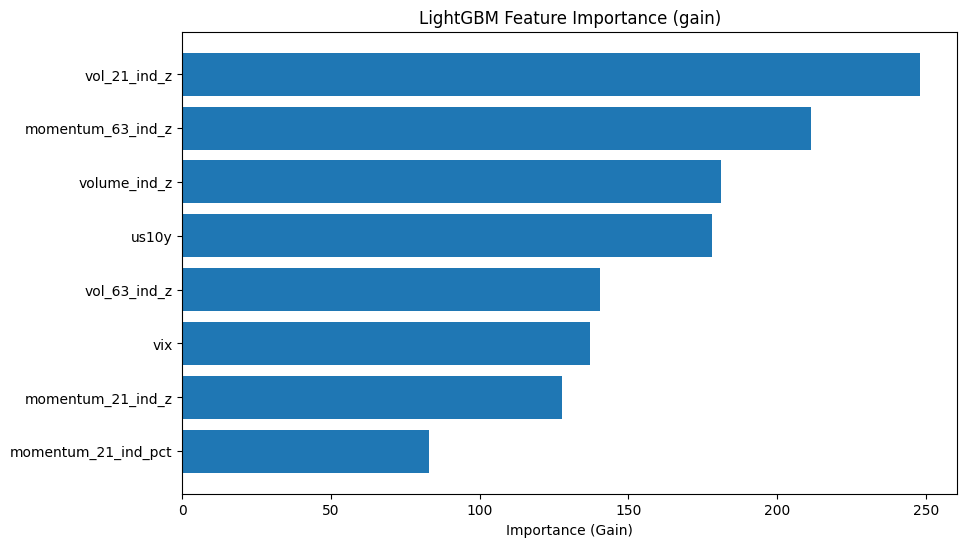

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': Xtr.columns,
    'importance_gain': ranker.booster_.feature_importance(importance_type='gain'),
    'importance_split': ranker.booster_.feature_importance(importance_type='split')
})

# Sort by gain
feature_importance = feature_importance.sort_values('importance_gain', ascending=False)

print(feature_importance)

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance_gain'])
plt.gca().invert_yaxis()
plt.title("LightGBM Feature Importance (gain)")
plt.xlabel("Importance (Gain)")
plt.show()
